# <center>Проект 5</br>Задача регрессии</center>

## Оглавление

* [Импорт библиотек](#Импорт-библиотек)
* [1. Знакомство с данными, базовый анализ и расширение данных](#1.-Знакомство-с-данными,-базовый-анализ-и-расширение-данных)
* [2. Разведывательный анализ данных (EDA)](#2.-Разведывательный-анализ-данных-(EDA))
* [3. Отбор и преобразование признаков](#3.-Отбор-и-преобразование-признаков)
* [4. Решение задачи регрессии: линейная регрессия и деревья решений](#4.-Решение-задачи-регрессии:-линейная-регрессия-и-деревья-решений)
* [5. Решение задачи регрессии: ансамблевые методы и построение прогноза](#5.-Решение-задачи-регрессии:-ансамблевые-методы-и-построение-прогноза)

К сожалению, ссылки внутри ноутбука не работают на GitHub. Необходимо либо скачать ноутбук, либо перейти по [ссылке](https://nbviewer.org/github/DS-Makovetskiy/DS/blob/main/Project_5_Regression_task/Project_5_Regression_task.ipynb).

Файлы данных, доступны по [ссылке](https://drive.google.com/drive/folders/1yxlIf0SaURha0hLmTsxmxbse67sI6UA-?usp=sharing)

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

from scipy import stats
import xgboost as xgb

from data_preprocessing import add_datetime_features
from data_preprocessing import add_holiday_features
from data_preprocessing import add_osrm_features
from data_preprocessing import add_geographical_features
from data_preprocessing import add_cluster_features
from data_preprocessing import add_weather_features
from data_preprocessing import fill_null_weather_data

## 1. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 

Прочитаем наш файл с исходными данными:

In [3]:
taxi_data = pd.read_csv("data/train.csv")

print(f'Train data shape: {taxi_data.shape}')
display(taxi_data.head(3))

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

Посмотрим на временные рамки, в которых мы работаем с данными.

In [4]:
taxi_data['pickup_datetime']  = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

min_date = taxi_data['pickup_datetime'].dt.date.min()
max_date = taxi_data['pickup_datetime'].dt.date.max()

print(f'Данные представлены в интервале от: {min_date} до {max_date}')

Данные представлены в интервале от: 2016-01-01 до 2016-06-30


Посмотрим на пропуски.

In [5]:
display(taxi_data.isna().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Посмотрим на статистические характеристики некоторых признаков. 
* Сколько уникальных таксопарков присутствует в данных?
* Каково максимальное количество пассажиров?
* Чему равна средняя и медианная длительность поездки? Ответ приведем в секундах и округлим до целого.
* Чему равно минимальное и максимальное время поездки (в секундах)?

In [6]:
print(f'Количество уникальных таксопарков: {taxi_data["vendor_id"].nunique()}')
print(f'Максимальное количество пассажиров: {taxi_data["passenger_count"].max()}')
print(f'Длительность поездки - средняя: {round(taxi_data["trip_duration"].mean())}, медианная: {round(taxi_data["trip_duration"].median())} секунд')
print(f'Минимальное и максимальное время поездки - {round(taxi_data["trip_duration"].min())} и {round(taxi_data["trip_duration"].max())} секунд')

Количество уникальных таксопарков: 2
Максимальное количество пассажиров: 9
Длительность поездки - средняя: 959, медианная: 662 секунд
Минимальное и максимальное время поездки - 1 и 3526282 секунд


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


Реализуем функцию **add_datetime_features()**, которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

In [7]:
taxi_data = add_datetime_features(taxi_data)

display(taxi_data.head(3))

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday


Посмотрим:
* Сколько поездок было совершено в субботу?
* Сколько поездок в среднем совершается в день?

In [8]:
saturday_trips = taxi_data[taxi_data['pickup_day_of_week'] == 'Saturday'].shape[0]
trips_per_day = round(taxi_data['pickup_datetime'].dt.date.value_counts().mean())

print(f'{saturday_trips} поездок было совершено в субботу')
print(f'В среднем, {trips_per_day} поездок совершается в день')

220868 поездок было совершено в субботу
В среднем, 8015 поездок совершается в день


Реализуем функцию **add_holiday_features()**, которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

In [9]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

taxi_data = add_holiday_features(taxi_data, holiday_data)

In [10]:
holiday_trip_median = round(taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median())
print(f'Медианная длительность поездки на такси в праздничные дни составляет {holiday_trip_median} секунд')

Медианная длительность поездки на такси в праздничные дни составляет 585 секунд


Проверим чему равна медианная длительность поездки на такси в праздничные дни?

Реализуем функцию **add_osrm_features()**, которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [11]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')

taxi_data = add_osrm_features(taxi_data, osrm_data)

display(taxi_data.head(3))

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0


Проверим:
* Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 
* Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [12]:
taxi_trip_duration = taxi_data['trip_duration'].median()
osrm_trip_duration = taxi_data['total_travel_time'].median()
res_trip_duration  = round(taxi_trip_duration - osrm_trip_duration)

osmr_null = taxi_data[taxi_data['total_distance'].isna()].shape[0]

print(f'Разница медианной длительностью поездки меду исходными и OSRM данными составляет {res_trip_duration} секунды')
print(f'Количество пустых строк в данных OSRM: {osmr_null}')

Разница медианной длительностью поездки меду исходными и OSRM данными составляет 372 секунды
Количество пустых строк в данных OSRM: 1


Реализуем функцию **add_geographical_features()**, которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

In [13]:
taxi_data = add_geographical_features(taxi_data)

Посмотрим, чему равно медианное расстояние Хаверсина поездок (в киллометрах)?

In [14]:
print(f'Медианное расстояние Хаверсина поездок равно {round(taxi_data["haversine_distance"].median(), 2)} километра')

Медианное расстояние Хаверсина поездок равно 2.09 километра


Реализуем функцию **add_cluster_features()**, которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [15]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))

# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

c:\Users\Dmitriy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=42)

In [16]:
taxi_data = add_cluster_features(taxi_data, kmeans)

Посмотрим, сколько поездок содержится в наименьшем по размеру географическом кластере?

In [17]:
min_trip_count = taxi_data["geo_cluster"].value_counts(ascending=True).values[0]

print(f'В наименьшем по размеру географическом кластере содержится {min_trip_count} поездки')

В наименьшем по размеру географическом кластере содержится 2 поездки


In [18]:
weather_data = pd.read_csv('data/weather_data.csv', 
                           usecols=['time', 
                                    'temperature', 
                                    'visibility', 
                                    'wind speed', 
                                    'precip', 
                                    'events']
                           )


taxi_data = add_weather_features(taxi_data, weather_data)

snow_trip = taxi_data[taxi_data["events"] == "Snow"].shape[0]
print(f'{snow_trip} поездок было совершено в снежную погоду')

gaps_percentage = round((taxi_data['temperature'].isna().sum() / taxi_data.shape[0]) * 100, 2)
print(f'Доля пропусков в новых признаках составляет {gaps_percentage}% от общего числа данных')

13126 поездок было совершено в снежную погоду
Доля пропусков в новых признаках составляет 0.82% от общего числа данных


Реализуем функцию **fill_null_weather_data()**, которая принимает на вход таблицу с данными о поездках и заполняет пропущенные значения в столбцах.

* Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполним медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. 
* Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 
* Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам. 

In [19]:
taxi_data = fill_null_weather_data(taxi_data)

Проверим чему равна медиана в столбце temperature после заполнения пропусков.

In [20]:
print(f'Медианное значение температуры равно: {taxi_data["temperature"].median()}')

Медианное значение температуры равно: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу.

Воспользуемся информацией о кратчайшем расстоянии, которое проезжает такси. Вычислим среднюю скорость автомобиля на кратчайшем пути следующим образом: 

$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$

Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


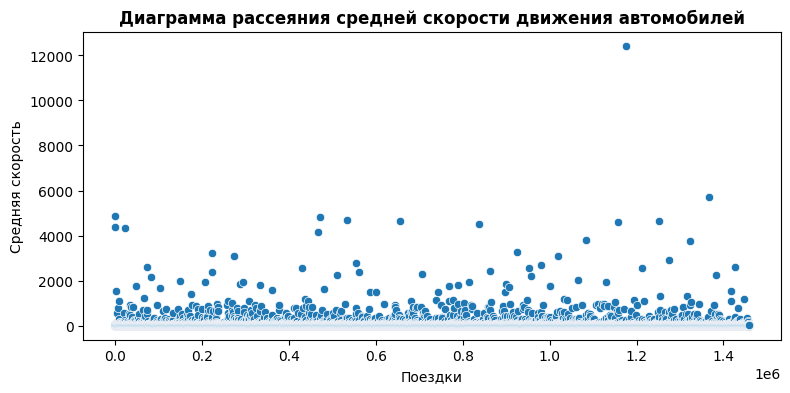

In [21]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6

fig, ax = plt.subplots(figsize=(9, 4))
sns.scatterplot(
    x  = avg_speed.index, 
    y  = avg_speed, 
    ax = ax)
plt.title('Диаграмма рассеяния средней скорости движения автомобилей', fontweight='bold')
ax.set_xlabel('Поездки')
ax.set_ylabel('Средняя скорость');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


Найдем поездки, длительность которых превышает 24 часа. И удалим их из набора данных.
* Сколько выбросов по признаку длительности поездки удалось найти?

Найдем поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалим их из данных. 
* Сколько выбросов по признаку скорости удалось найти?

In [22]:
trip_duration_outlier = taxi_data[taxi_data['trip_duration'] > 24*3600]

print(f'Количество выбросов по длительности поездки: {trip_duration_outlier.shape[0]}')

taxi_data = taxi_data.drop(trip_duration_outlier.index, axis=0)

Количество выбросов по длительности поездки: 4


In [23]:
mask = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
total_distance_outlier = taxi_data[mask > 300]

print(f'Количество выбросов по скорости поездки: {total_distance_outlier.shape[0]}')

taxi_data = taxi_data.drop(total_distance_outlier.index, axis=0)

Количество выбросов по скорости поездки: 407


[&#8679; к оглавлению](#Оглавление)

## 2. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями;

Начинаем с целевого признака. 

Основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:

$$trip\_duration\_log = log(trip\_duration+1),$$

где под символом log подразумевается натуральный логарифм.


In [24]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).

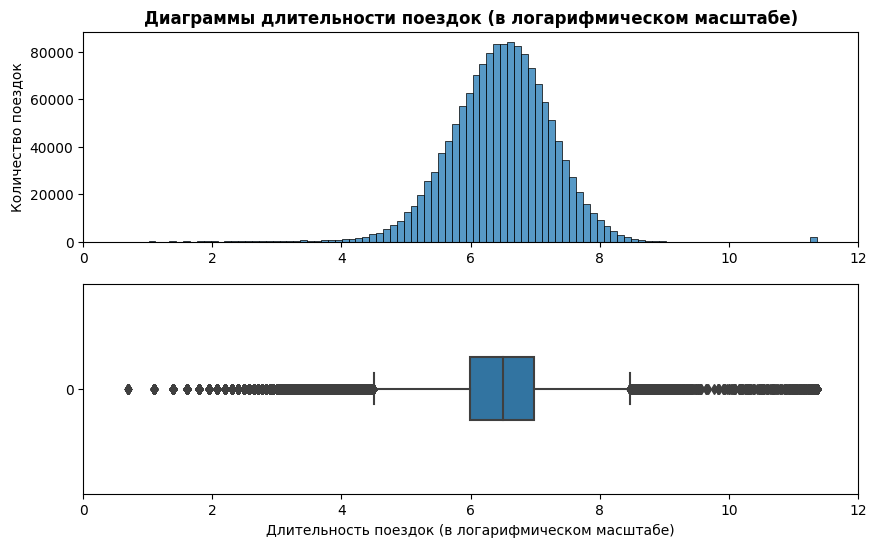

In [25]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
max_xlim  = round(taxi_data['trip_duration_log'].max()) + 1

sns.histplot(
    taxi_data['trip_duration_log'],
    bins = 100,
    ax   = axis[0])
axis[0].set_title('Диаграммы длительности поездок (в логарифмическом масштабе)', fontweight='bold')
axis[0].set_xlabel('')
axis[0].set_ylabel('Количество поездок')
axis[0].set_xlim(0, max_xlim)

sns.boxplot(
    taxi_data['trip_duration_log'],
    orient = 'h',
    width  = 0.3,
    ax     = axis[1])
axis[1].set_xlabel('Длительность поездок (в логарифмическом масштабе)')
axis[1].set_ylabel('')
axis[1].set_xlim(0, max_xlim);

Проверим, является ли полученное распределение нормальным?

In [26]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

alpha = 0.05


_, p = stats.normaltest(taxi_data['trip_duration_log'])
print('p-value = %.2f' % p)

# if p > alpha:
if p > alpha / 2:
    print(H0, '\n')
else:
    print(Ha, '\n')

p-value = 0.00
Данные не распределены нормально (мы отвергаем H0) 



Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

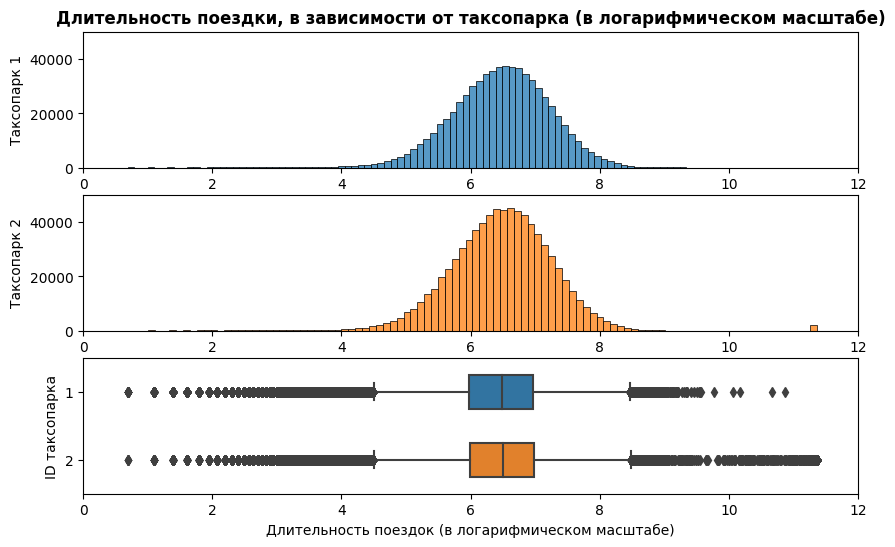

In [27]:
fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))
colors    = sns.color_palette('tab10')
max_xlim  = round(taxi_data['trip_duration_log'].max()) + 1

sns.histplot(
    taxi_data[taxi_data['vendor_id'] == 1],
    x    = 'trip_duration_log',
    bins = 100,
    ax   = axis[0])
axis[0].set_title('Длительность поездки, в зависимости от таксопарка (в логарифмическом масштабе)', fontweight='bold')
axis[0].set_xlabel('')
axis[0].set_ylabel('Таксопарк 1')
axis[0].set_xlim(0, max_xlim)
axis[0].set_ylim(0, 50000)

sns.histplot(
    taxi_data[taxi_data['vendor_id'] == 2],
    x     = 'trip_duration_log',
    color = colors[1],
    bins  = 100,
    ax    = axis[1])
axis[1].set_xlabel('')
axis[1].set_ylabel('Таксопарк 2')
axis[1].set_xlim(0, max_xlim)
axis[1].set_ylim(0, 50000)

sns.boxplot(
    taxi_data,
    x      = 'trip_duration_log',
    y      = 'vendor_id',
    orient = 'h',
    width  = 0.5,
    ax     = axis[2])
axis[2].set_xlabel('Длительность поездок (в логарифмическом масштабе)')
axis[2].set_ylabel('ID таксопарка')
axis[2].set_xlim(0, max_xlim);

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

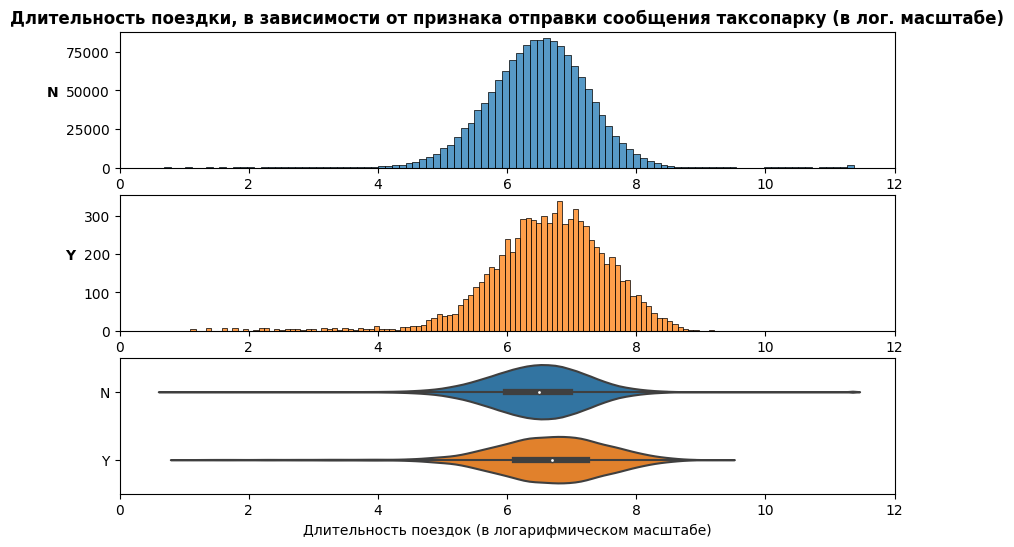

In [28]:
fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))
colors    = sns.color_palette('tab10')
max_xlim  = round(taxi_data['trip_duration_log'].max()) + 1

sns.histplot(
    taxi_data[taxi_data['store_and_fwd_flag'] == 'N'],
    x    = 'trip_duration_log',
    bins = 100,
    ax   = axis[0])
axis[0].set_title('Длительность поездки, в зависимости от признака отправки сообщения таксопарку (в лог. масштабе)', fontweight='bold')
axis[0].set_xlabel('')
axis[0].set_ylabel('N   ', rotation='horizontal', fontweight='bold')
axis[0].set_xlim(0, max_xlim)

sns.histplot(
    taxi_data[taxi_data['store_and_fwd_flag'] == 'Y'],
    x     = 'trip_duration_log',
    color = colors[1],
    bins  = 100,
    ax    = axis[1])
axis[1].set_xlabel('')
axis[1].set_ylabel('Y   ', rotation='horizontal', fontweight='bold')
axis[1].set_xlim(0, max_xlim)

sns.violinplot(
    taxi_data,
    x      = 'trip_duration_log',
    y      = 'store_and_fwd_flag',
    orient = 'h',
    width  = 0.8,
    ax     = axis[2])
axis[2].set_xlabel('Длительность поездок (в логарифмическом масштабе)')
axis[2].set_ylabel('')
axis[2].set_xlim(0, max_xlim);

Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

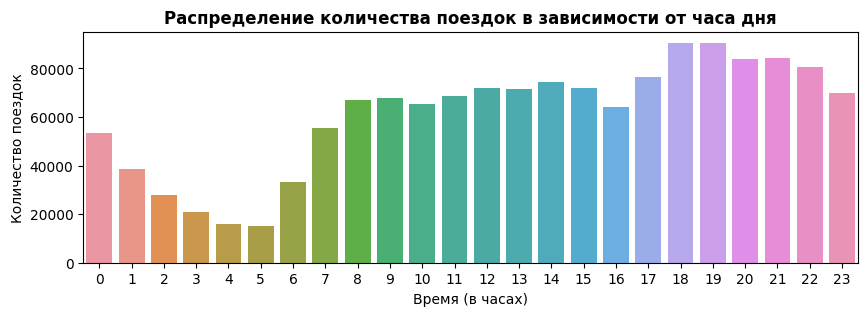

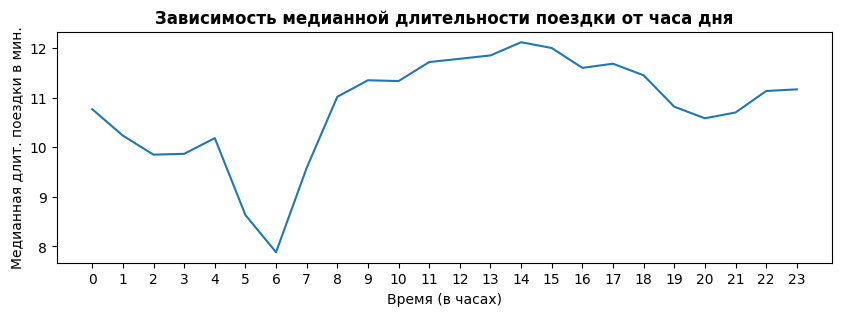

In [29]:
fig, axis = plt.subplots(figsize=(10, 3))
countplot = sns.countplot(
    taxi_data,
    x = 'pickup_hour')
countplot.set_title('Распределение количества поездок в зависимости от часа дня', fontweight='bold')
countplot.set_xlabel('Время (в часах)')
countplot.set_ylabel('Количество поездок')


median_tdh = taxi_data.groupby(by='pickup_hour')['trip_duration'].median()

fig, axis = plt.subplots(figsize=(10, 3))
lineplot  = sns.lineplot(median_tdh / 60)
lineplot.set_title('Зависимость медианной длительности поездки от часа дня', fontweight='bold')
lineplot.set_xlabel('Время (в часах)')
lineplot.set_ylabel('Медианная длит. поездки в мин.')
lineplot.set_xticks(np.arange(0, 24, 1));

Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
* Зависимость медианной длительности поездки от дня недели.

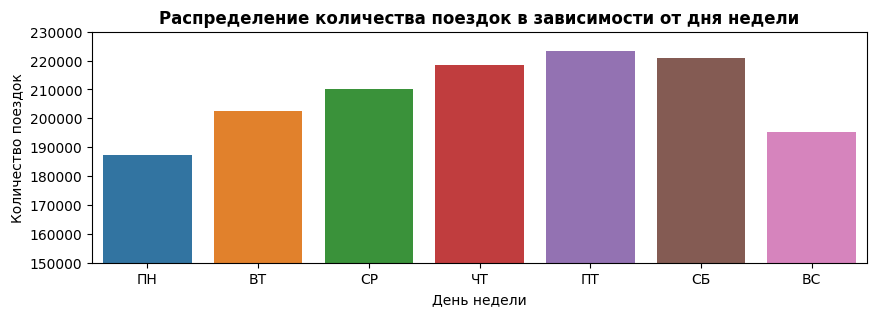

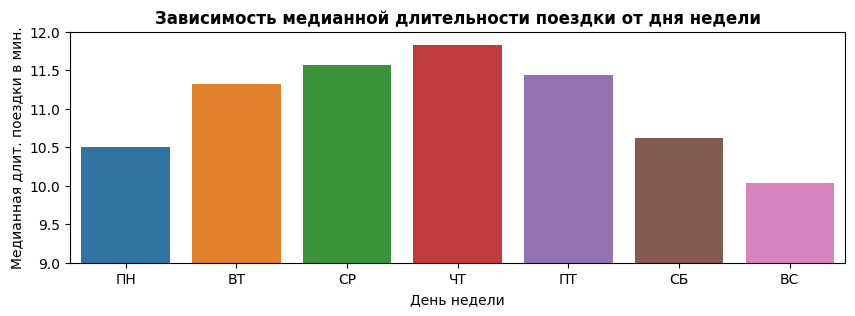

In [30]:
DOW_order    = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_of_week = ['ПН', 'ВТ', 'СР', 'ЧТ', 'ПТ', 'СБ', 'ВС']

fig, axis = plt.subplots(figsize=(10, 3))
countplot = sns.countplot(
    taxi_data,
    x     = 'pickup_day_of_week',
    order = DOW_order)
countplot.set_title('Распределение количества поездок в зависимости от дня недели', fontweight='bold')
countplot.set_xlabel('День недели')
countplot.set_ylabel('Количество поездок')
countplot.set_xticklabels(days_of_week)
countplot.set_ylim(150000, 230000)


median_tdw = taxi_data.groupby(by='pickup_day_of_week')['trip_duration'].median()

fig, axis = plt.subplots(figsize=(10, 3))
barplot   = sns.barplot(
    x     = median_tdw.index,
    y     = median_tdw.values / 60,
    order = DOW_order)
barplot.set_title('Зависимость медианной длительности поездки от дня недели', fontweight='bold')
barplot.set_xlabel('День недели')
barplot.set_ylabel('Медианная длит. поездки в мин.')
barplot.set_xticklabels(days_of_week)
barplot.set_ylim(9, 12);

Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой будут отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

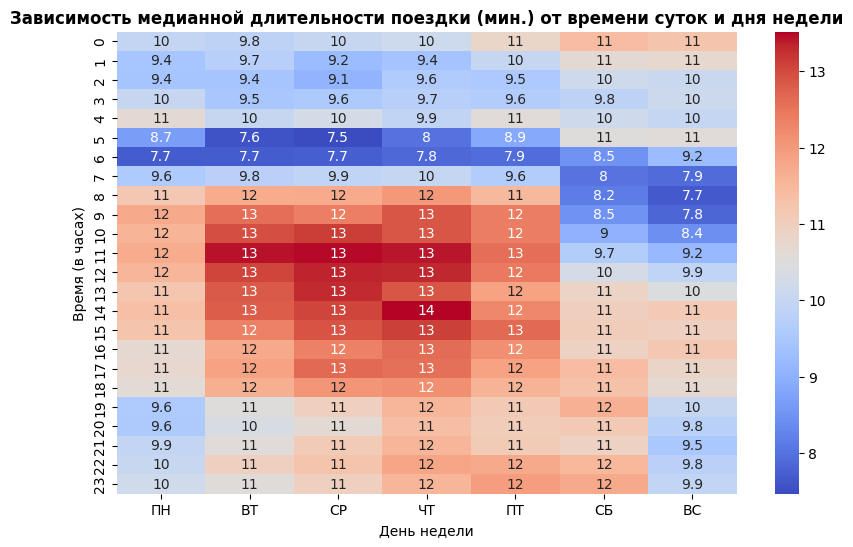

In [31]:
pivot_table = taxi_data.pivot_table(
                            index   = 'pickup_hour',
                            columns = 'pickup_day_of_week',
                            values  = 'trip_duration',
                            aggfunc = 'median'    
                        )

# переупорядочим столбцы сводной таблицы в правильном порядке
pivot_table = pivot_table.reindex(columns=DOW_order)

fig = plt.subplots(figsize=(10, 6))
heatmap = sns.heatmap(
    data  = pivot_table / 60,
    annot = True,
    cmap  = 'coolwarm')
heatmap.set_title('Зависимость медианной длительности поездки (мин.) от времени суток и дня недели', fontweight='bold')
heatmap.set_xlabel('День недели')
heatmap.set_ylabel('Время (в часах)')
heatmap.set_xticklabels(days_of_week);

Построим две диаграммы рассеяния:
* первая будет иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая будет иллюстрировать географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка, добавив следующие ограничения на границы осей абсцисс и ординат:
 
**city_long_border = (-74.03, -73.75)**

**city_lat_border = (40.63, 40.85)**

Добавим на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.   


In [32]:
city_long_border = (-74.03, -73.75)
city_lat_border  = (40.63, 40.85)


p_lng_min = taxi_data['pickup_longitude'] >= city_long_border[0]
p_lng_max = taxi_data['pickup_longitude'] <= city_long_border[1]
p_lat_min = taxi_data['pickup_latitude']  >= city_lat_border[0]
p_lat_max = taxi_data['pickup_latitude']  <= city_lat_border[1]

pickup_geo_data = taxi_data[p_lng_min & p_lng_max & p_lat_min & p_lat_max][['pickup_longitude', 'pickup_latitude', 'geo_cluster']]


d_lng_min = taxi_data['dropoff_longitude'] >= city_long_border[0]
d_lng_max = taxi_data['dropoff_longitude'] <= city_long_border[1]
d_lat_min = taxi_data['dropoff_latitude']  >= city_lat_border[0]
d_lat_max = taxi_data['dropoff_latitude']  <= city_lat_border[1]

dropoff_geo_data = taxi_data[d_lng_min & d_lng_max & d_lat_min & d_lat_max][['dropoff_longitude', 'dropoff_latitude', 'geo_cluster']]

print(f'Количество кластеров для начала маршрута: {pickup_geo_data["geo_cluster"].unique()}')
print(f'Количество кластеров для завершения маршрута: {dropoff_geo_data["geo_cluster"].unique()}')

Количество кластеров для начала маршрута: [9 4 0 5 1 3 7 6]
Количество кластеров для завершения маршрута: [9 4 0 5 1 3 7]


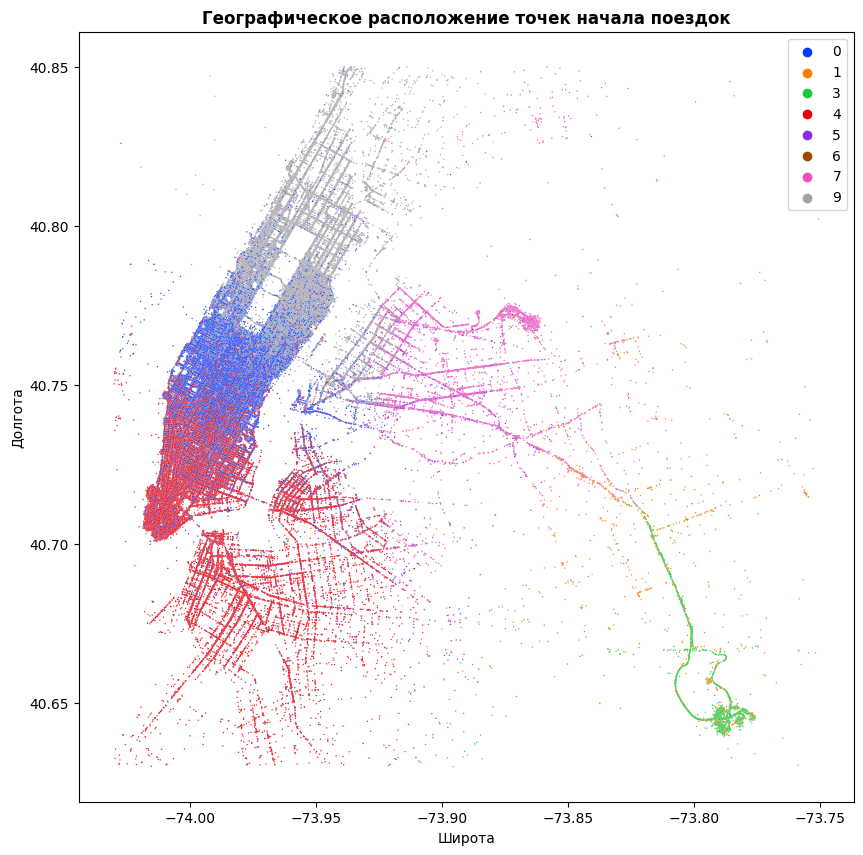

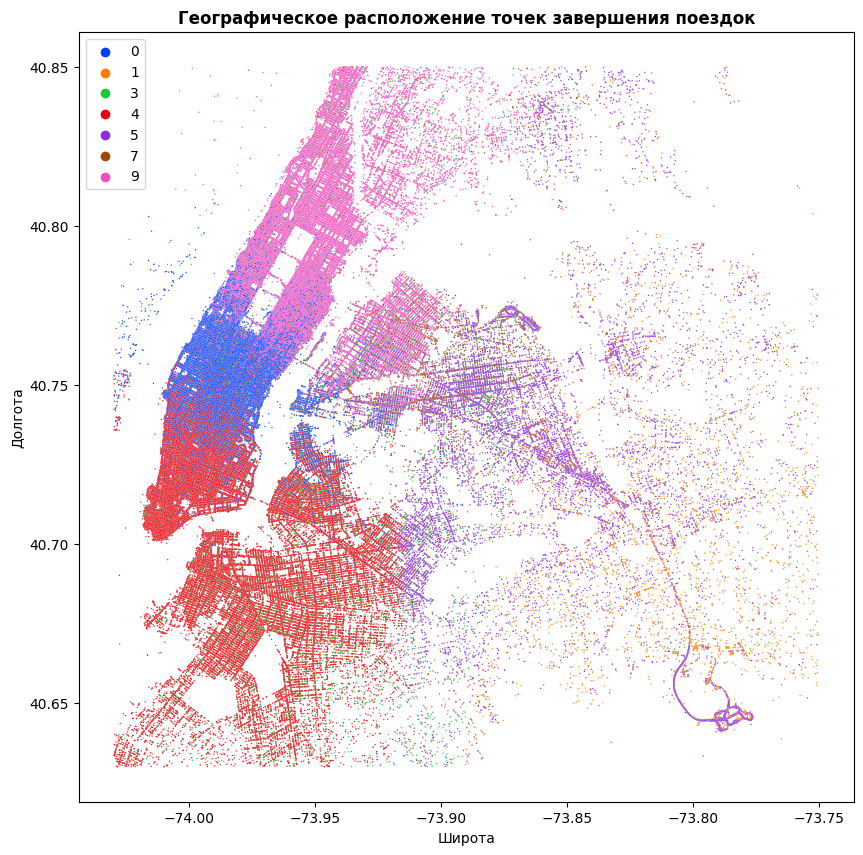

In [33]:
fig = plt.subplots(figsize=(10, 10))

pickup_scatterplot = sns.scatterplot(
                        data = pickup_geo_data,
                        x       = 'pickup_longitude',
                        y       = 'pickup_latitude',
                        hue     = 'geo_cluster',
                        palette = 'bright',
                        s       = 1)
pickup_scatterplot.set_title('Географическое расположение точек начала поездок', fontweight='bold')
pickup_scatterplot.set_xlabel('Широта')
pickup_scatterplot.set_ylabel('Долгота')
pickup_scatterplot.legend(loc='best')


fig = plt.subplots(figsize=(10, 10))

dropoff_scatterplot = sns.scatterplot(
                        data=dropoff_geo_data,
                        x       = 'dropoff_longitude',
                        y       = 'dropoff_latitude',
                        hue     = 'geo_cluster',
                        palette = 'bright',
                        s       = 1)
dropoff_scatterplot.set_title('Географическое расположение точек завершения поездок', fontweight='bold')
dropoff_scatterplot.set_xlabel('Широта')
dropoff_scatterplot.set_ylabel('Долгота')
dropoff_scatterplot.legend(loc='best');

[&#8679; к оглавлению](#Оглавление)

## 3. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Закодировать категориальные признаки;
* Отобрать признаки, которые мы будем использовать для обучения модели;
* Масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.

In [34]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [35]:
train_data = taxi_data.copy()
train_data.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527


Удалим лишние признаки

In [36]:
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)

print(train_data.shape)

(1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [37]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)

print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


Закодируем признак **vendor_id** таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируем признак **store_and_fwd_flag** таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

In [38]:
train_data['vendor_id']          = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

Создадим таблицу **data_onehot** из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

In [39]:
OHE = preprocessing.OneHotEncoder(drop='first')
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

data_onehot  = OHE.fit_transform(train_data[columns_to_change]).toarray()
column_names = OHE.get_feature_names_out(columns_to_change)

data_onehot  = pd.DataFrame(data_onehot, columns=column_names)

print(f'С помощью однократного кодирования, было сгенерировано {data_onehot.shape[1]} признаков')

С помощью однократного кодирования, было сгенерировано 18 признаков


Добавим полученную таблицу с закодированными признаками:

In [40]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)

print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений **X**, вектор целевой переменной **y** и его логарифм **y_log**. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:

In [41]:
X     = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y     = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [42]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, 
    y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе.

осмотрим на признаки, которые вошли в список отобранных.

In [43]:
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train, y_train_log)

top_features = selector.get_feature_names_out()

print(f'Список 25 отобранных признаков, имеющих наибольшее значение для предсказания:\n\n{top_features}')

Список 25 отобранных признаков, имеющих наибольшее значение для предсказания:

['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_Monday'
 'pickup_day_of_week_Saturday' 'pickup_day_of_week_Sunday'
 'pickup_day_of_week_Thursday' 'pickup_day_of_week_Tuesday'
 'pickup_day_of_week_Wednesday' 'geo_cluster_1' 'geo_cluster_3'
 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_9']


In [44]:
X_train = X_train[top_features]
X_valid = X_valid[top_features]

Выполним масштабирование факторов

Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler.

In [45]:
col_names = X_train.columns

MMScaler = preprocessing.MinMaxScaler()

X_train = MMScaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=col_names)

X_valid = MMScaler.transform(X_valid)
X_valid = pd.DataFrame(X_valid, columns=col_names)

[&#8679; к оглавлению](#Оглавление)

## 4. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать **RMSLE (Root Mean Squared Log Error)**, которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



Построим модель линейной регрессии на обучающей выборке (факторы нормализованы, целевая переменная в логарифмическом масштабе).

In [46]:
LR = linear_model.LinearRegression()
LR.fit(X_train, y_train_log)

LR_y_train_pred = LR.predict(X_train)
LR_y_valid_pred = LR.predict(X_valid)

RMSLE_LR_train = metrics.mean_squared_error(y_train_log, LR_y_train_pred, squared=False).round(2)
RMSLE_LR_valid = metrics.mean_squared_error(y_valid_log, LR_y_valid_pred, squared=False).round(2)

print(f'RMSLE, модели линейной регрессии на тренировочной выборке: {RMSLE_LR_train}')
print(f'RMSLE, модели линейной регрессии на валидационной выборке: {RMSLE_LR_valid}')

RMSLE, модели линейной регрессии на тренировочной выборке: 0.54
RMSLE, модели линейной регрессии на валидационной выборке: 0.54


Построим модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы нормализованы, целевая переменная в логарифмическом масштабе).

In [47]:
PF = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
PF.fit(X_train)

PF_X_train = PF.transform(X_train)
PF_X_valid = PF.transform(X_valid)

PF_LR = linear_model.LinearRegression()
PF_LR.fit(PF_X_train, y_train_log)

PF_LR_y_train_pred = PF_LR.predict(PF_X_train)
PF_LR_y_valid_pred = PF_LR.predict(PF_X_valid)

RMSLE_PF_LR_train = metrics.mean_squared_error(y_train_log, PF_LR_y_train_pred, squared=False).round(2)
RMSLE_PF_LR_valid = metrics.mean_squared_error(y_valid_log, PF_LR_y_valid_pred, squared=False).round(2)

print(f'RMSLE, модели полиномиальной регрессии 2-ой степени на тренировочной выборке: {RMSLE_PF_LR_train}')
print(f'RMSLE, модели полиномиальной регрессии 2-ой степени на валидационной выборке: {RMSLE_PF_LR_valid}')

RMSLE, модели полиномиальной регрессии 2-ой степени на тренировочной выборке: 0.47
RMSLE, модели полиномиальной регрессии 2-ой степени на валидационной выборке: 0.7


Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке (факторы нормализованы, целевая переменная в логарифмическом масштабе).

In [48]:
PF_LR_L2 = linear_model.Ridge(alpha=1)
PF_LR_L2.fit(PF_X_train, y_train_log)

PF_LR_L2_y_train_pred = PF_LR_L2.predict(PF_X_train)
PF_LR_L2_y_valid_pred = PF_LR_L2.predict(PF_X_valid)

RMSLE_PF_LR_L2_train = metrics.mean_squared_error(y_train_log, PF_LR_L2_y_train_pred, squared=False).round(2)
RMSLE_PF_LR_L2_valid = metrics.mean_squared_error(y_valid_log, PF_LR_L2_y_valid_pred, squared=False).round(2)

print(f'RMSLE, модели полиномиальной регрессии 2-ой степени с L2 регуляризацией на тренировочной выборке: {RMSLE_PF_LR_L2_train}')
print(f'RMSLE, модели полиномиальной регрессии 2-ой степени с L2 регуляризацией на валидационной выборке: {RMSLE_PF_LR_L2_valid}')

RMSLE, модели полиномиальной регрессии 2-ой степени с L2 регуляризацией на тренировочной выборке: 0.48
RMSLE, модели полиномиальной регрессии 2-ой степени с L2 регуляризацией на валидационной выборке: 0.48


Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы нормализованы, целевая переменная в логарифмическом масштабе).

In [49]:
DTR = tree.DecisionTreeRegressor(random_state=42)
DTR.fit(X_train, y_train_log)

DTR_y_train_pred = DTR.predict(X_train)
DTR_y_valid_pred = DTR.predict(X_valid)

RMSLE_DTR_train = metrics.mean_squared_error(y_train_log, DTR_y_train_pred, squared=False).round(2)
RMSLE_DTR_valid = metrics.mean_squared_error(y_valid_log, DTR_y_valid_pred, squared=False).round(2)

print(f'RMSLE, модели дерева решений на тренировочной выборке: {RMSLE_DTR_train}')
print(f'RMSLE, модели дерева решений на валидационной выборке: {RMSLE_DTR_valid}')

RMSLE, модели дерева решений на тренировочной выборке: 0.0
RMSLE, модели дерева решений на валидационной выборке: 0.57


Переберем все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

Постройим линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

Определим оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

In [50]:
# param_grid = [{'max_depth': range(7, 20)}]

# GS = model_selection.GridSearchCV(
#     estimator  = tree.DecisionTreeRegressor(random_state=42),
#     param_grid = param_grid,
#     n_jobs     = -1
# )
# GS.fit(X_train, y_train_log)

# print(f'Оптимальное значение максимальной глубины дерева: {GS.best_params_["max_depth"]}')

# GS_y_train_pred = GS.predict(X_train)
# GS_y_valid_pred = GS.predict(X_valid)

# RMSLE_GS_train = metrics.mean_squared_error(y_train_log, GS_y_train_pred, squared=False).round(2)
# RMSLE_GS_valid = metrics.mean_squared_error(y_valid_log, GS_y_valid_pred, squared=False).round(2)

# print(f'RMSLE, модели дерева решений на тренировочной выборке: {RMSLE_GS_train}')
# print(f'RMSLE, модели дерева решений на валидационной выборке: {RMSLE_GS_valid}')

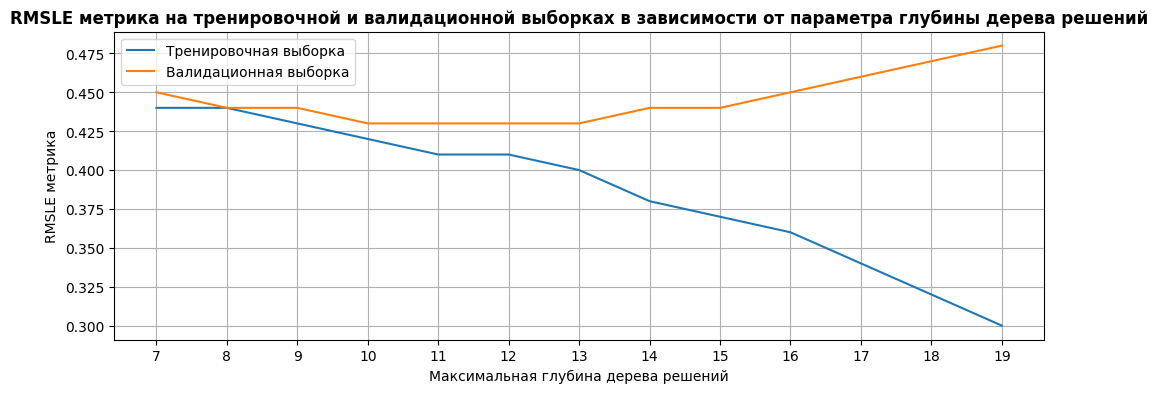

In [51]:
max_depth = range(7, 20)
train_scores = []
valid_scores = []

for depth in max_depth:
    DTRm = tree.DecisionTreeRegressor(max_depth=depth, random_state=42)
    DTRm.fit(X_train, y_train_log)
    
    DTRm_y_train_pred = DTRm.predict(X_train)
    DTRm_y_valid_pred = DTRm.predict(X_valid)
    
    train_scores.append(metrics.mean_squared_error(y_train_log, DTRm_y_train_pred, squared=False).round(2))
    valid_scores.append(metrics.mean_squared_error(y_valid_log, DTRm_y_valid_pred, squared=False).round(2))


fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(x=max_depth, y=train_scores, label='Тренировочная выборка')
sns.lineplot(x=max_depth, y=valid_scores, label='Валидационная выборка')
ax.set_title('RMSLE метрика на тренировочной и валидационной выборках в зависимости от параметра глубины дерева решений', fontweight='bold')
ax.set_xlabel('Максимальная глубина дерева решений')
ax.set_ylabel('RMSLE метрика')
ax.set_xticks(max_depth)
ax.grid();

In [52]:
DTRm = tree.DecisionTreeRegressor(random_state=42, max_depth=12)
DTRm.fit(X_train, y_train_log)

DTRm_y_train_pred = DTRm.predict(X_train)
DTRm_y_valid_pred = DTRm.predict(X_valid)

RMSLE_DTRm_train = metrics.mean_squared_error(y_train_log, DTRm_y_train_pred, squared=False).round(2)
RMSLE_DTRm_valid = metrics.mean_squared_error(y_valid_log, DTRm_y_valid_pred, squared=False).round(2)

print(f'RMSLE, модели дерева решений на тренировочной выборке: {RMSLE_DTRm_train}')
print(f'RMSLE, модели дерева решений на валидационной выборке: {RMSLE_DTRm_valid}')

RMSLE, модели дерева решений на тренировочной выборке: 0.41
RMSLE, модели дерева решений на валидационной выборке: 0.43


[&#8679; к оглавлению](#Оглавление)

## 5. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

Постром модель случайного леса на обучающей выборке (факторы нормализованы, целевая переменная в логарифмическом масштабе). 

В качестве гиперпараметров, установим следующие:
* n_estimators = 200,
* max_depth = 12,
* criterion = 'squared_error',
* min_samples_split = 20,
* random_state = 42

In [54]:
RFR = ensemble.RandomForestRegressor(
    n_estimators      = 200,
    max_depth         = 12,
    criterion         = 'squared_error',
    min_samples_split = 20,
    random_state      = 42,
    n_jobs            = -1,
    verbose           = True
)
RFR.fit(X_train, y_train_log)

RFR_y_train_pred = RFR.predict(X_train)
RFR_y_valid_pred = RFR.predict(X_valid)

RMSLE_RFR_train = metrics.mean_squared_error(y_train_log, RFR_y_train_pred, squared=False).round(2)
RMSLE_RFR_valid = metrics.mean_squared_error(y_valid_log, RFR_y_valid_pred, squared=False).round(2)

print(f'RMSLE, модели случайного леса на тренировочной выборке: {RMSLE_RFR_train}')
print(f'RMSLE, модели случайного леса на валидационной выборке: {RMSLE_RFR_valid}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 31.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   23.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.1s


RMSLE, модели случайного леса на тренировочной выборке: 0.4
RMSLE, модели случайного леса на валидационной выборке: 0.41


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    9.5s finished


Построим модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы нормализованы, целевая переменная в логарифмическом масштабе). 

В качестве гиперпараметров, установим следующие:
* learning_rate = 0.5,
* n_estimators = 100,
* max_depth = 6, 
* min_samples_split = 30,
* random_state = 42

In [55]:
GBR = ensemble.GradientBoostingRegressor(
    learning_rate     = 0.5,
    n_estimators      = 100,
    max_depth         = 6,
    min_samples_split = 30,
    random_state      = 42,
    verbose           = True
)
GBR.fit(X_train, y_train_log)

GBR_y_train_pred = GBR.predict(X_train)
GBR_y_valid_pred = GBR.predict(X_valid)

RMSLE_GBR_train = metrics.mean_squared_error(y_train_log, GBR_y_train_pred, squared=False).round(2)
RMSLE_GBR_valid = metrics.mean_squared_error(y_valid_log, GBR_y_valid_pred, squared=False).round(2)

print(f'RMSLE, модели градиентного бустинга на тренировочной выборке: {RMSLE_GBR_train}')
print(f'RMSLE, модели градиентного бустинга на валидационной выборке: {RMSLE_GBR_valid}')

      Iter       Train Loss   Remaining Time 


         1           0.3110           40.55m
         2           0.2247           39.48m
         3           0.1987           38.64m
         4           0.1875           38.03m
         5           0.1821           37.67m
         6           0.1789           37.16m
         7           0.1742           36.79m
         8           0.1721           36.30m
         9           0.1705           35.79m
        10           0.1694           35.54m
        20           0.1585           35.84m
        30           0.1532           30.18m
        40           0.1500           26.85m
        50           0.1468           21.40m
        60           0.1439           16.63m
        70           0.1421           12.17m
        80           0.1402            7.94m
        90           0.1383            3.85m
       100           0.1371            0.00s
RMSLE, модели градиентного бустинга на тренировочной выборке: 0.37
RMSLE, модели градиентного бустинга на валидационной выборке: 0.39


**Модель градиентного бустинга показала наилучший результат по метрике RMSLE на валидационной выборке - 0.39**

Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

Посмотрим топ-3 наиболее значимых для предсказания целевого признака (длительности поездки в логарифмическом масштабе) факторов.

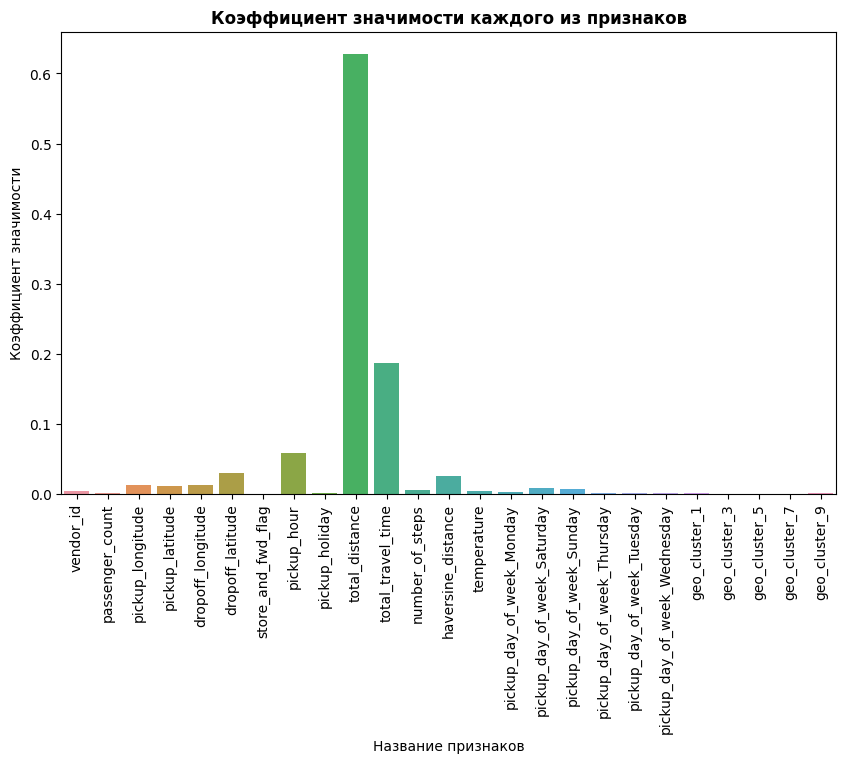

In [56]:
feature_names = GBR.feature_names_in_
importances   = GBR.feature_importances_

fig = plt.subplots(figsize=(10, 6))

barplot = sns.barplot(
    x = feature_names, 
    y = importances)
barplot.set_title('Коэффициент значимости каждого из признаков', fontweight='bold')
barplot.set_xlabel('Название признаков')
barplot.xaxis.set_tick_params(rotation=90)
barplot.set_ylabel('Коэффициент значимости');

Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:

$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведем в минуты и округлим до десятых.

In [57]:
change_scale = np.vectorize(lambda x: np.exp(x) - 1)

y_valid_orig = change_scale(y_valid_log)
y_pred_orig  = change_scale(GBR_y_valid_pred)

MeAE = round(metrics.median_absolute_error(y_valid_orig, y_pred_orig) / 60, 1)

print(f'MeAE, модели градиентного бустинга в изначальном масштабе: {MeAE} минут')

MeAE, модели градиентного бустинга в изначальном масштабе: 1.8 минут


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [58]:
test_data      = pd.read_csv("data/Project5_test_data.csv")
osrm_data_test = pd.read_csv("data/Project5_osrm_data_test.csv")
test_id        = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [59]:
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')

test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id']          = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

test_data_onehot = OHE.fit_transform(test_data[columns_to_change]).toarray()
column_names     = OHE.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)

X_test        = test_data[top_features]
X_test_scaled = MMScaler.transform(X_test)

print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [60]:
y_train_log.shape, y_valid_log.shape

((977016,), (481217,))

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудем перевести предсказания из логарифмического масштаба в истинный, используя формулу:

$$y_i=exp(z_i)-1$$

После того, как предсказание длительности поездок на тестовой выборке будет сформировано, необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

In [61]:
GBR_y_test_pred = GBR.predict(X_test)

y_test_predict  = change_scale(GBR_y_test_pred)


submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

[&#8679; к оглавлению](#Оглавление)

### **В качестве бонуса**

Попробуем улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [64]:
# создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=top_features)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=top_features)
dtest  = xgb.DMatrix(X_test_scaled, feature_names=top_features)

Обучим модель XGBoost

In [65]:
# гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 
            'eta':              0.1, 
            'colsample_bytree': 0.9, 
            'max_depth':        6, 
            'subsample':        0.9, 
            'lambda':           1, 
            'nthread':          -1, 
            'booster' :         'gbtree', 
            'eval_metric':      'rmse', 
            'objective':        'reg:squarederror'
           }

# тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# обучаем модель XGBoost
model = xgb.train(
    params                = xgb_pars,
    dtrain                = dtrain,
    num_boost_round       = 300,
    evals                 = watchlist,
    early_stopping_rounds = 20,
    maximize              = False,
    verbose_eval          = 10
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93575	valid-rmse:1.93569
[20]	train-rmse:0.78507	valid-rmse:0.78592
[30]	train-rmse:0.47892	valid-rmse:0.48093
[40]	train-rmse:0.42050	valid-rmse:0.42312
[50]	train-rmse:0.40890	valid-rmse:0.41187
[60]	train-rmse:0.40421	valid-rmse:0.40761
[70]	train-rmse:0.40130	valid-rmse:0.40512
[80]	train-rmse:0.39910	valid-rmse:0.40326
[90]	train-rmse:0.39715	valid-rmse:0.40159
[100]	train-rmse:0.39544	valid-rmse:0.40017
[110]	train-rmse:0.39415	valid-rmse:0.39928
[120]	train-rmse:0.39297	valid-rmse:0.39832
[130]	train-rmse:0.39152	valid-rmse:0.39718
[140]	train-rmse:0.39054	valid-rmse:0.39654
[150]	train-rmse:0.38924	valid-rmse:0.39552
[160]	train-rmse:0.38870	valid-rmse:0.39516
[170]	train-rmse:0.38805	valid-rmse:0.39483
[180]	train-rmse:0.38737	valid-rmse:0.39443
[190]	train-rmse:0.38648	valid-rmse:0.39376
[200]	train-rmse:0.38582	valid-rmse:0.39334
[210]	train-rmse:0.38518	valid-rmse:0.39316
[220]	train-rmse:0.38468	valid-rmse:0.39291

In [66]:
#делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1

print('Modeling RMSLE %.2f' % model.best_score)

Modeling RMSLE 0.39


In [67]:
submission_xgb = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission_xgb.to_csv('data/submission_xgb.csv', index=False)

Посмотрим на важность признаков

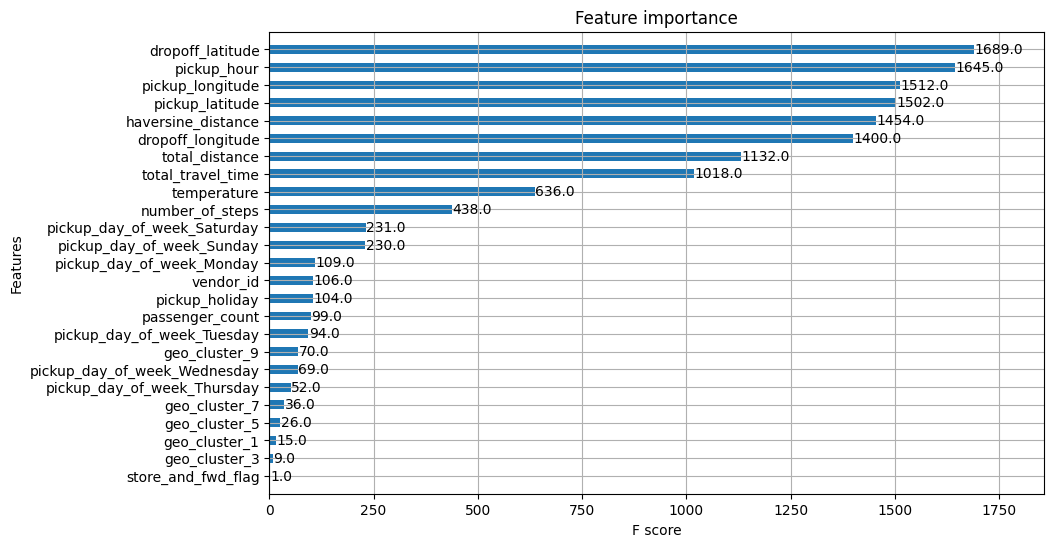

In [68]:
fig, ax = plt.subplots(figsize=(10,6))

xgb.plot_importance(model, ax=ax, height=0.5);

[&#8679; к оглавлению](#Оглавление)